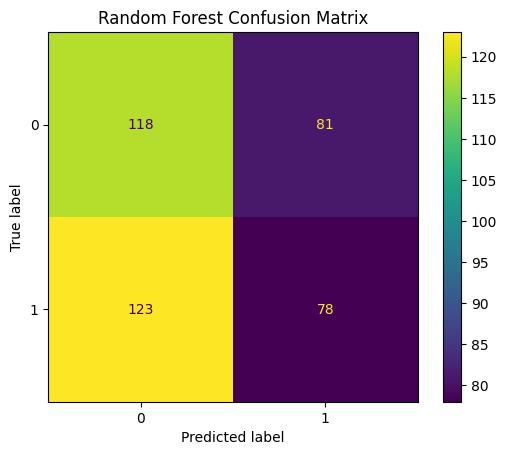

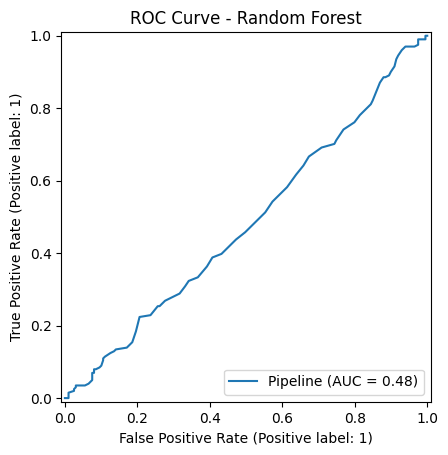

Receiver Operating Characteristic curve


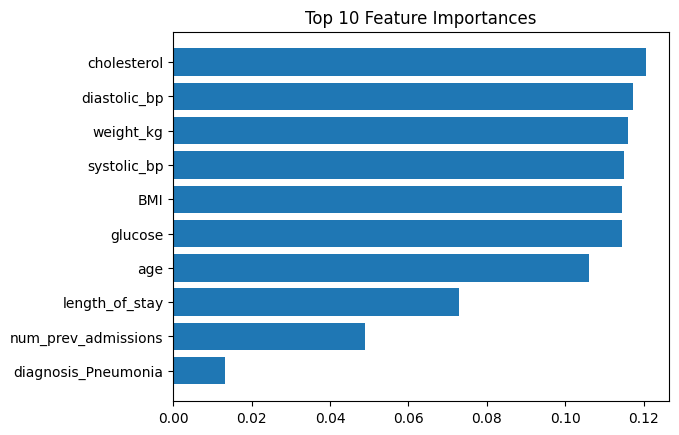

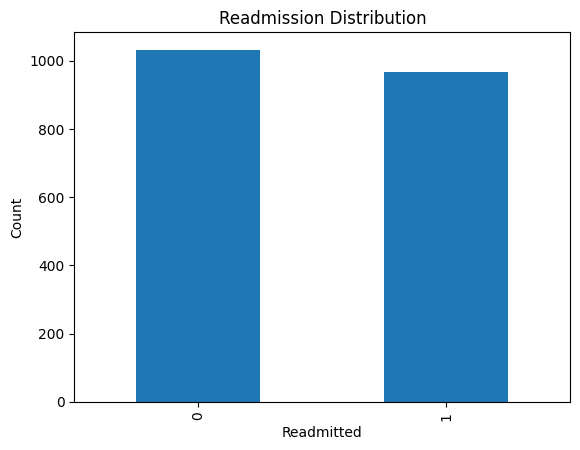

TN: 118
FP: 81
FN: 123
TP: 78
Accuracy: 0.49
Precision: 0.49056603773584906
Recall: 0.3880597014925373
F1 Score: 0.4333333333333333

TP = True Positives (correctly predicted readmissions)
TN = True Negatives (correctly predicted non-readmissions)
FP = False Positives (predicted readmission but didn’t happen)
FN = False Negatives (missed readmissions — critical in healthcare)

Bias & Fairness Analysis (Critical in Healthcare)

Female 0.4230769230769231
Male 0.35051546391752575

Model Calibration


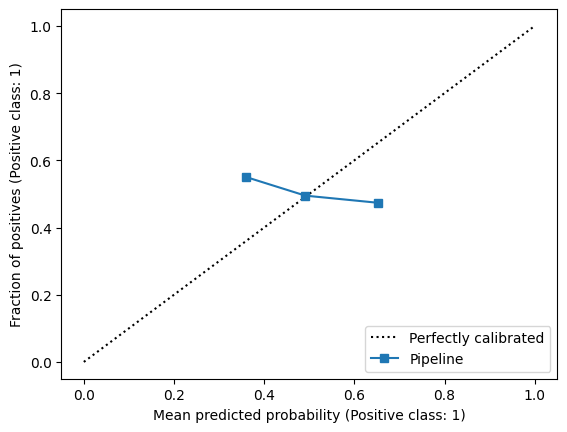

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
import numpy as np

np.random.seed(42)


n = 2000

data = pd.DataFrame({
    "age": np.random.randint(18, 90, n),
    "gender": np.random.choice(["Male", "Female"], n),
    "weight_kg": np.random.normal(75, 15, n),
    "height_cm": np.random.normal(170, 10, n),
    "systolic_bp": np.random.normal(130, 20, n),
    "diastolic_bp": np.random.normal(80, 10, n),
    "cholesterol": np.random.normal(200, 40, n),
    "glucose": np.random.normal(110, 30, n),
    "num_prev_admissions": np.random.poisson(1.5, n),
    "length_of_stay": np.random.randint(1, 15, n),
    "diagnosis": np.random.choice(
        ["Heart Failure", "Diabetes", "Pneumonia", "COPD"], n
    )
})

# Risk-based readmission probability
risk = (
    0.02 * data["age"] +
    0.5 * data["num_prev_admissions"] +
    0.1 * data["length_of_stay"] +
    0.01 * data["glucose"]
)

prob = 1 / (1 + np.exp(-0.01 * (risk - risk.mean())))
data["readmitted_30_days"] = np.random.binomial(1, prob)

# Introduce missingness
for col in ["cholesterol", "glucose"]:
    data.loc[data.sample(frac=0.05).index, col] = np.nan

#feature engineering
data["height_m"] = data["height_cm"] / 100
data["BMI"] = data["weight_kg"] / (data["height_m"] ** 2)

data.drop(columns=["height_cm", "height_m"], inplace=True)

#Define features
X = data.drop("readmitted_30_days", axis=1)
y = data["readmitted_30_days"]

categorical = ["gender", "diagnosis"]
numerical = [col for col in X.columns if col not in categorical]

#preprocessing pipeline
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical),
    ("cat", categorical_transformer, categorical)
])

#Train test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#logistic Regression
log_model = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

log_model.fit(X_train, y_train)

#Random Forest
rf_model = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=200))
])

rf_model.fit(X_train, y_train)

#metrics function
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1:", f1_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))

#Evaluate Models
#from sklearn.metrics import ConfusionMatrixDisplay

#ConfusionMatrixDisplay.from_estimator(
#    rf_model, X_test, y_test
#)
#plt.title("Random Forest Confusion Matrix")
#plt.show()

#Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    rf_model, X_test, y_test
)
plt.title("Random Forest Confusion Matrix")
plt.show()

#ROC Curve
RocCurveDisplay.from_estimator(
    rf_model, X_test, y_test
)
plt.title("ROC Curve - Random Forest")
plt.show()

print('Receiver Operating Characteristic curve')
#Feature Importance
feature_names = (
    numerical +
    list(
        rf_model.named_steps["preprocessing"]
        .named_transformers_["cat"]
        .named_steps["onehot"]
        .get_feature_names_out(categorical)
    )
)

importances = rf_model.named_steps["classifier"].feature_importances_

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

plt.figure()
plt.barh(
    importance_df["feature"][:10],
    importance_df["importance"][:10]
)
plt.title("Top 10 Feature Importances")
plt.gca().invert_yaxis()
plt.show()

#Outcome Distribution
plt.figure()
data["readmitted_30_days"].value_counts().plot(kind="bar")
plt.title("Readmission Distribution")
plt.xlabel("Readmitted")
plt.ylabel("Count")
plt.show()

#Extract TP, TN, FP, FN
from sklearn.metrics import confusion_matrix

y_pred = rf_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("TN:", tn)
print("FP:", fp)
print("FN:", fn)
print("TP:", tp)

#Manually Compute Metrics From Confusion Matrix
accuracy = (tp + tn) / (tp + tn + fp + fn)

precision = tp / (tp + fp)

recall = tp / (tp + fn)

f1 = 2 * (precision * recall) / (precision + recall)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

print()
print('TP = True Positives (correctly predicted readmissions)')

print('TN = True Negatives (correctly predicted non-readmissions)')

print('FP = False Positives (predicted readmission but didn’t happen)')

print('FN = False Negatives (missed readmissions — critical in healthcare)')

print()
#Bias & Fairness Analysis (Critical in Healthcare)
print("Bias & Fairness Analysis (Critical in Healthcare)")
print()
for group in X_test["gender"].unique():
    idx = X_test["gender"] == group
    print(group, recall_score(y_test[idx], y_pred[idx]))

#Model Calibration
print()
print("Model Calibration")
from sklearn.calibration import CalibrationDisplay

CalibrationDisplay.from_estimator(rf_model, X_test, y_test)
plt.show()